# Full Workflow {.unnumbered} 

## Packages

In [1]:
import sys
import os
import geopandas as gpd
import xarray as xr
import rioxarray as rio
import json

# Add the parent directory to sys.path
sys.path.append(os.path.abspath(os.path.join('scripts')))

# from scripts.config import *
from scripts.utils import create_cube_subset, create_paths
from scripts.load_aux_data_01 import load_aux_data
from scripts.cube_preprocessing_02 import cube_preprocess
from scripts.base_analysis_03 import base_analysis, change_plot, plot_timeseries
from scripts.config import variables
from scripts.modelling_functions import plot_multiple_results;
import matplotlib.pyplot as plt

# Write data to disk set to False
write_data = False


def plot_multiple_results(results_dict, time_index = None):
    num_plots = len(results_dict)
    num_cols = 2
    num_rows = (num_plots + 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(17, num_rows * 7))
    if num_rows * num_cols > 1:
        axes = axes.flatten()  # Flatten the axes array for easier iteration
    else:
        axes = [axes]  # Ensure axes is iterable

    for i, (lat_lon, data_dict) in enumerate(results_dict.items()):
        ax = axes[i]

        testY = data_dict['results']['true_values']
        forecasts = data_dict['results']['predicted_values']
        mae = data_dict['evaluation']['mae']
        rmse = data_dict['evaluation']['rmse']

        # Assuming lat_lon keys are in the format "(lat, lon)" and need to be converted from string
        lat, lon = eval(lat_lon)  # Convert the string key back to tuple if necessary

        # Generate a time index from the length of the testY data
        # time_index = range(len(testY))

        ax.plot(time_index, testY, label="Actual")
        ax.plot(time_index, forecasts, label="Predicted")
        ax.set_title(f"Lat: {lat}, Lon: {lon}")
        ax.set_xlabel("Time")
        ax.set_ylabel("Value")
        ax.legend()
        ax.grid(True)

        # Add MSE to the corner
        ax.text(0.95, 0.05, f"RMSE: {rmse:.2f}, MAE: {mae:.2f}", 
                verticalalignment='bottom', horizontalalignment='right', 
                transform=ax.transAxes, color='red', fontsize=12)

    # Adjust the layout to prevent overlap and make sure all plots are visible
    plt.tight_layout()
    plt.show()


def plot_forecasts_from_dict(results_dict):
    """
    This function takes a dictionary containing model results and creates plots for the two locations
    with the highest and two locations with the lowest RMSE values.

    Args:
    results_dict (dict): Dictionary containing model results with true and predicted values.

    Returns:
    None
    """
    # Extract RMSEs and corresponding locations
    rmse_values = {loc: data['evaluation']['rmse'] for loc, data in results_dict.items()}

    # Sort locations by RMSE
    sorted_locations = sorted(rmse_values, key=rmse_values.get)

    # Find two locations with highest and two with lowest RMSE
    lowest_rmse_locations = sorted_locations[:2]
    highest_rmse_locations = sorted_locations[-2:]

    print(f'Locations with lowest RMSE: {lowest_rmse_locations}, RMSEs: {[rmse_values[loc] for loc in lowest_rmse_locations]}')
    print(f'Locations with highest RMSE: {highest_rmse_locations}, RMSEs: {[rmse_values[loc] for loc in highest_rmse_locations]}')

    # Function to plot true vs predicted values
    def plot_forecast(true_values, predicted_values, title):
        plt.figure(figsize=(14, 7))
        plt.plot(true_values, label='True Values', color='blue', linewidth=2)
        plt.plot(predicted_values, label='Predicted Values', color='red', linestyle='--', linewidth=2)
        plt.title(title, fontsize=16)
        plt.xlabel('Time', fontsize=14)
        plt.ylabel('SIF', fontsize=14)
        plt.legend(fontsize=12)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # Plot for locations with lowest RMSE
    for loc in lowest_rmse_locations:
        true_values = results_dict[loc]['results']['true_values']
        predicted_values = results_dict[loc]['results']['predicted_values']
        plot_forecast(
            [val[0] for val in true_values],
            [val[0] for val in predicted_values],
            f'Forecast vs True Values (Lowest RMSE Location: {loc})'
        )

    # Plot for locations with highest RMSE
    for loc in highest_rmse_locations:
        true_values = results_dict[loc]['results']['true_values']
        predicted_values = results_dict[loc]['results']['predicted_values']
        plot_forecast(
            [val[0] for val in true_values],
            [val[0] for val in predicted_values],
            f'Forecast vs True Values (Highest RMSE Location: {loc})'
        )



2024-07-28 12:22:16.639184: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-28 12:22:16.641545: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-28 12:22:16.677667: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-28 12:22:17.475964: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:

def plot_multiple_results(results_dict, keys_to_plot=None, time_index=None):
    # If no specific keys are provided, plot all entries in the dictionary
    if keys_to_plot is None:
        keys_to_plot = list(results_dict.keys())
    
    num_plots = len(keys_to_plot)
    num_cols = 2
    num_rows = (num_plots + 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(17, num_rows * 7))
    if num_rows * num_cols > 1:
        axes = axes.flatten()  # Flatten the axes array for easier iteration
    else:
        axes = [axes]  # Ensure axes is iterable

    for i, lat_lon in enumerate(keys_to_plot):
        ax = axes[i]
        data_dict = results_dict[lat_lon]
        testY = data_dict['results']['true_values']
        forecasts = data_dict['results']['predicted_values']
        mae = data_dict['evaluation']['mae']
        rmse = data_dict['evaluation']['rmse']

        # Assuming lat_lon keys are in the format "(lat, lon)" and need to be converted from string
        lat, lon = eval(lat_lon)  # Convert the string key back to tuple if necessary

        # Generate a time index from the length of the testY data if not provided
        if time_index is None:
            time_index = range(len(testY))

        ax.plot(time_index, testY, label="Actual")
        ax.plot(time_index, forecasts, label="Predicted")
        ax.set_title(f"Lat: {lat}, Lon: {lon}")
        ax.set_xlabel("Time")
        ax.set_ylabel("Value")
        ax.legend()
        ax.grid(True)

        # Add RMSE and MAE to the corner
        ax.text(0.95, 0.05, f"RMSE: {rmse:.2f}, MAE: {mae:.2f}", 
                verticalalignment='bottom', horizontalalignment='right', 
                transform=ax.transAxes, color='red', fontsize=12)

    # Adjust the layout to prevent overlap and make sure all plots are visible
    plt.tight_layout()
    plt.show()


## Setup 

First we setup the data path and use create_paths() from utils to create paths necessary throughout the analysis.

Second we use create_subset() to create a subset of the Earth System Data Cube, croped to:

- our AOI, the extent of germany 
- the time span where the SIF variable is avaialble 
- to the relevant variables

[More Information](#sec-utils)

In [3]:
# Create a data directory
data_path = "data"
os.makedirs(data_path, exist_ok=True)

# Create paths to the data
germany_shp_path, corine_file_path, cube_sample_path, cube_crop_path, cube_crop_mask_path = create_paths(data_path=data_path)

# Create a subset of the Earth System Data Cube, containing only relevant variables and the desired spatial and temporal extent
cube_subset = create_cube_subset()

print(cube_subset)

<xarray.Dataset> Size: 30MB
Dimensions:                 (time: 920, lat: 31, lon: 37)
Coordinates:
  * lat                     (lat) float64 248B 47.38 47.62 47.88 ... 54.62 54.88
  * lon                     (lon) float64 296B 5.875 6.125 6.375 ... 14.62 14.88
  * time                    (time) datetime64[ns] 7kB 2002-01-05 ... 2021-12-31
    spatial_ref             int64 8B 0
Data variables:
    sif_gosif               (time, lat, lon) float32 4MB dask.array<chunksize=(222, 31, 25), meta=np.ndarray>
    evaporation_era5        (time, lat, lon) float32 4MB dask.array<chunksize=(222, 31, 25), meta=np.ndarray>
    precipitation_era5      (time, lat, lon) float32 4MB dask.array<chunksize=(222, 31, 25), meta=np.ndarray>
    radiation_era5          (time, lat, lon) float32 4MB dask.array<chunksize=(222, 31, 25), meta=np.ndarray>
    air_temperature_2m      (time, lat, lon) float32 4MB dask.array<chunksize=(222, 31, 25), meta=np.ndarray>
    max_air_temperature_2m  (time, lat, lon) float32 4

## Downloading auxillary data

The first part of the analysis is to download and preprocess all the necassaty auxillary data:

- download german border shapefile
- download and preprocess Corine data (for the forest mask) and use the border data to define the AOI
- create sif sample tif for spatial resolution and transform (used later to resample corine data)

[More Information](#sec-load_aux)

In [4]:
# Download auxiliary data (Germany border, Corine landcover data, sample tif)
load_aux_data(data_path, cube_subset, download = write_data)

# Load the germany border shapefile
germany_gpd = gpd.read_file(germany_shp_path)

----------------------------------------------------------------------------------------------------
Processing and downloading Corine data...
----------------------------------------------------------------------------------------------------
Sample path created at: data/cubes/cube_sif_sample.tif
----------------------------------------------------------------------------------------------------


## Preprocessing the cube 

Next we want to preprocess our data cube. 

This includes:

- croping the cube with the german border shape
 
- masking the cube with the corine forest cover:
   
  - Calculate the forest percentage of the Corine landcover data over the cube grid
  - add the forest percentages to the cube
  - add a binary forest cover layer to the cube (0 for <50% forest cover, 1 for >=50% forest cover)
  - use the layer to mask the cube

The results are cube_subset_crop which is croped with the germany border and cube_subset_mask, masked with the forest cover.

[More Information](#sec-cube_preproc)

In [5]:
# Crop the cube to the extent of Germany and mask it with the Corine landcover data (50% forest cover)
cube_subset_crop, cube_subset_mask = cube_preprocess(
        cube_subset, germany_gpd, corine_file_path, cube_sample_path, 
        out_path_crop=cube_crop_path, out_path_mask=cube_crop_mask_path, 
        all_touched=True, write=write_data
    )

Preprocessing cube
Clipping cube to Germany border
Calculate forest cover percentage over cube grid


## Basic Analysis of SIF-Data

The following part will

- Plot and save the timeseries of the mean SIF using the masked cube 
  
- Perform a change detection by calculating the summer mean for each year and the change for the year 2018 to the baseline up to 2017
  
- Resulting Plots:
  - Time-Series of SIF, considering only cells with more than 50% forest cover in 2000
  - Difference SIF 2018 to mean of 2002 - 2017 over all cells in germany 


In [6]:
# Calculate the temporal changes in the variables 
summer_sif_mean_cube, summer_mean_to_2017, changes = base_analysis(cube_subset_crop, years=[2018, 2019])

# Create the results directory
os.makedirs(os.path.join("results", "figures"), exist_ok=True)

# Calculate the summer mean for each year and the change compared to the baseline up to 2017
summer_mean_cube, summer_mean_to_2017, changes = base_analysis(cube_subset_crop, years=[2018, 2019])

# Select only year 2018
summer_mean_2018 = summer_sif_mean_cube.sel(year=2018)


***

**Show the summer means cube.**

In [7]:
summer_sif_mean_cube

<xarray.DataArray 'sif_gosif' (year: 20, lat: 31, lon: 37)> Size: 92kB
dask.array<stack, shape=(20, 31, 37), dtype=float32, chunksize=(1, 31, 25), chunktype=numpy.ndarray>
Coordinates:
  * lat          (lat) float64 248B 47.38 47.62 47.88 ... 54.38 54.62 54.88
  * lon          (lon) float64 296B 5.875 6.125 6.375 ... 14.38 14.62 14.88
    spatial_ref  int64 8B 0
  * year         (year) int64 160B 2002 2003 2004 2005 ... 2018 2019 2020 2021
Attributes: (12/25)
    acknowledgment:             https://doi.org/10.3390/rs11050517
    date_modified:              2022-10-11 22:20:05.841847
    description:                GOSIF Solar-Induced Chlorophyll Fluorescence ...
    geospatial_lat_max:         89.87499999999999
    geospatial_lat_min:         -89.87500000000001
    geospatial_lat_resolution:  0.25
    ...                         ...
    standard_name:              sif
    temporal_resolution:        8D
    time_coverage_end:          2021-12-31T00:00:00.000000000
    time_coverage_start:        2000-03-01T00:00:00.000000000
    time_period:                8D
    units:                      W m^-2 sr^-1 um^-1

***

**Plot summer means for the SIF variable for the reference period 2000-2017, 2018 and the difference of them.**

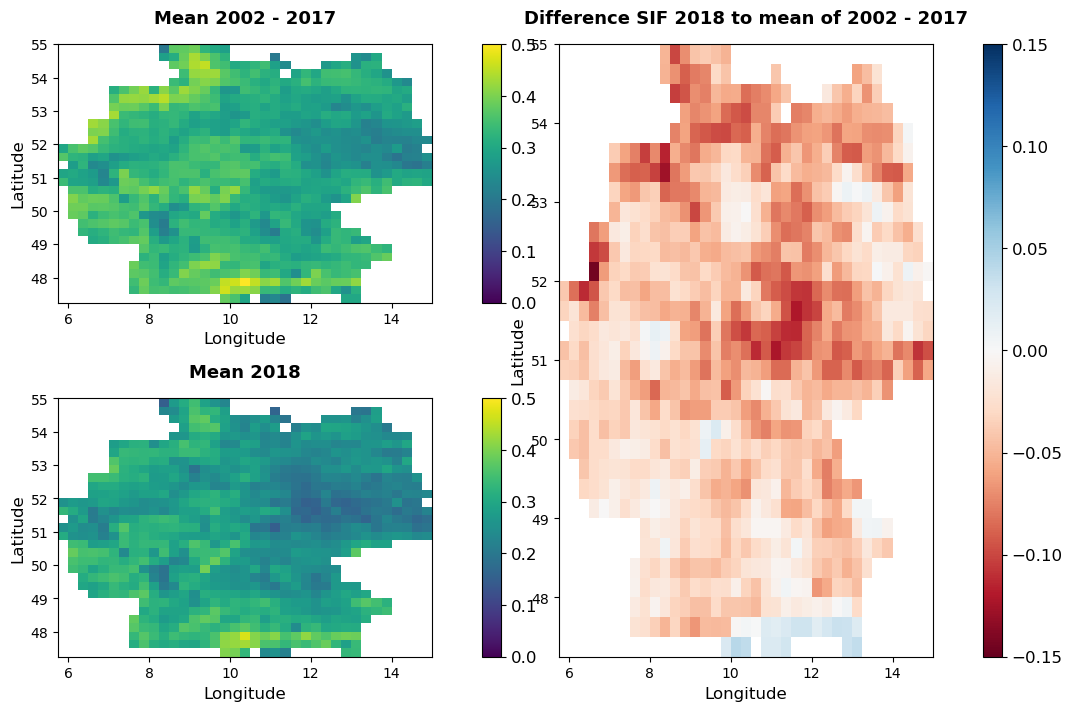

In [8]:
change_plot(ref_period = summer_mean_to_2017, data_2018 = summer_mean_2018, changes = changes);

*** 

**Plot Sif Time series (mean over masked cells in germany)**

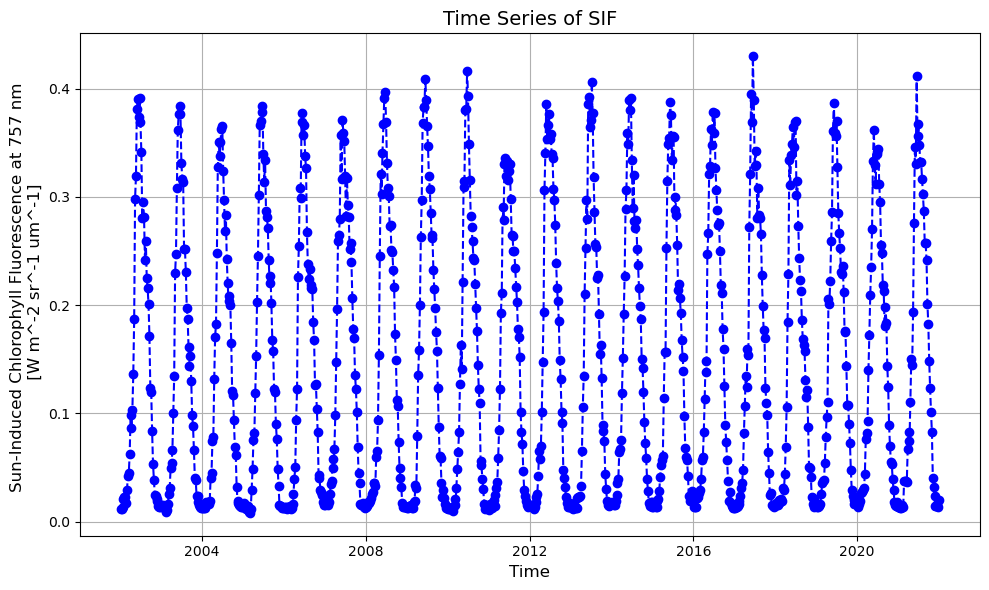

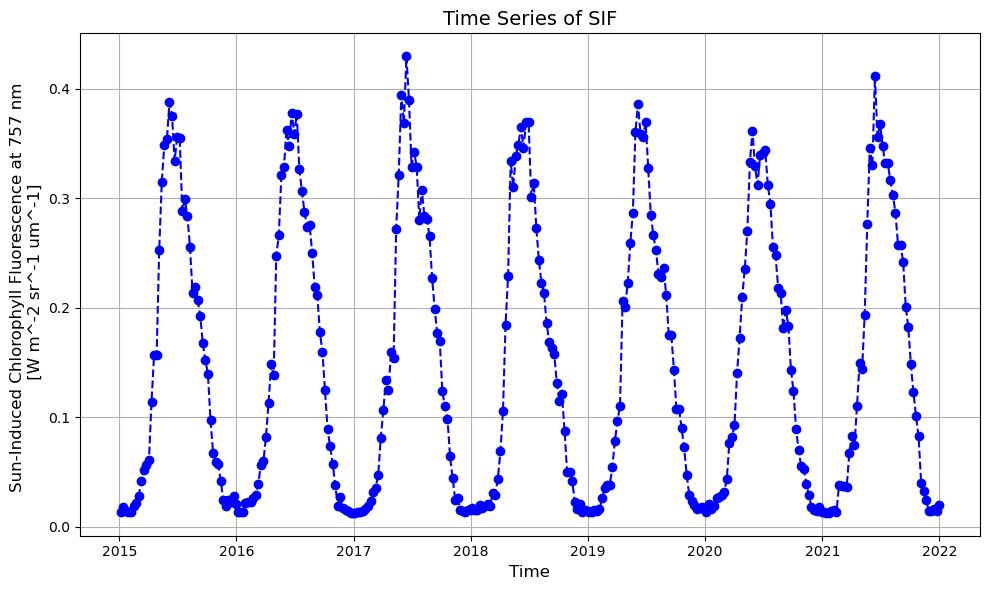

In [9]:
# Save plot of timeseries:
plot_timeseries(cube_subset_mask, save_path = os.path.join("results", "figures", "timeseries_full.png"))
plot_timeseries(cube_subset_mask, time_range= ["2015-01-01", "2022-12-31"], save_path = os.path.join("results", "figures", "timeseries_recent.png"))

## Modelling results

In [3]:
# Reading the results and evaluation from the file
with open("results/modelling/final/results_full_local_auto_l30.json", 'r') as file:
    results_dict = json.load(file)


In [4]:
rmse_values = {loc: data['evaluation']['rmse'] for loc, data in results_dict.items()}

# Find locations with highest and lowest RMSE
highest_rmse_location = max(rmse_values, key=rmse_values.get)
lowest_rmse_location = min(rmse_values, key=rmse_values.get)


print(f'Location with highest RMSE: {highest_rmse_location}, RMSE: {rmse_values[highest_rmse_location]}')
print(f'Location with lowest RMSE: {lowest_rmse_location}, RMSE: {rmse_values[lowest_rmse_location]}')

# Extracting true and predicted values for these locations
true_values_high_rmse = results_dict[highest_rmse_location]['results']['true_values']
predicted_values_high_rmse = results_dict[highest_rmse_location]['results']['predicted_values']
true_values_low_rmse = results_dict[lowest_rmse_location]['results']['true_values']
predicted_values_low_rmse = results_dict[lowest_rmse_location]['results']['predicted_values']

# scores for the locations
rmse_high = results_dict[highest_rmse_location]['evaluation']['rmse']
mae_high = results_dict[highest_rmse_location]['evaluation']['mae']
rmse_low = results_dict[lowest_rmse_location]['evaluation']['rmse']
mae_low = results_dict[lowest_rmse_location]['evaluation']['mae']


Location with highest RMSE: (52.625, 10.375), RMSE: 0.030957287177443504
Location with lowest RMSE: (52.125, 13.875), RMSE: 0.012908714823424816


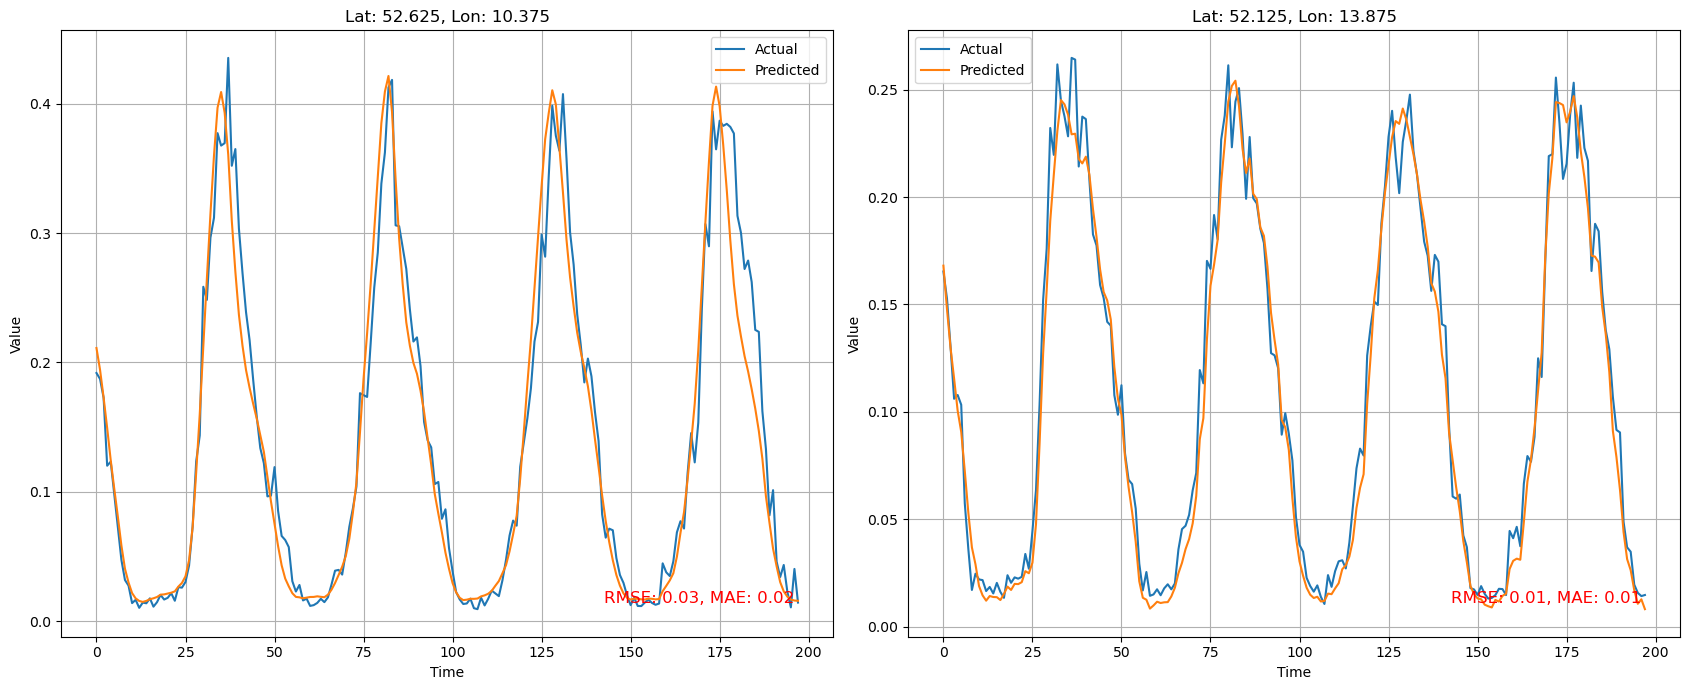

In [5]:
plot_multiple_results(results_dict, keys_to_plot=[highest_rmse_location, lowest_rmse_location])


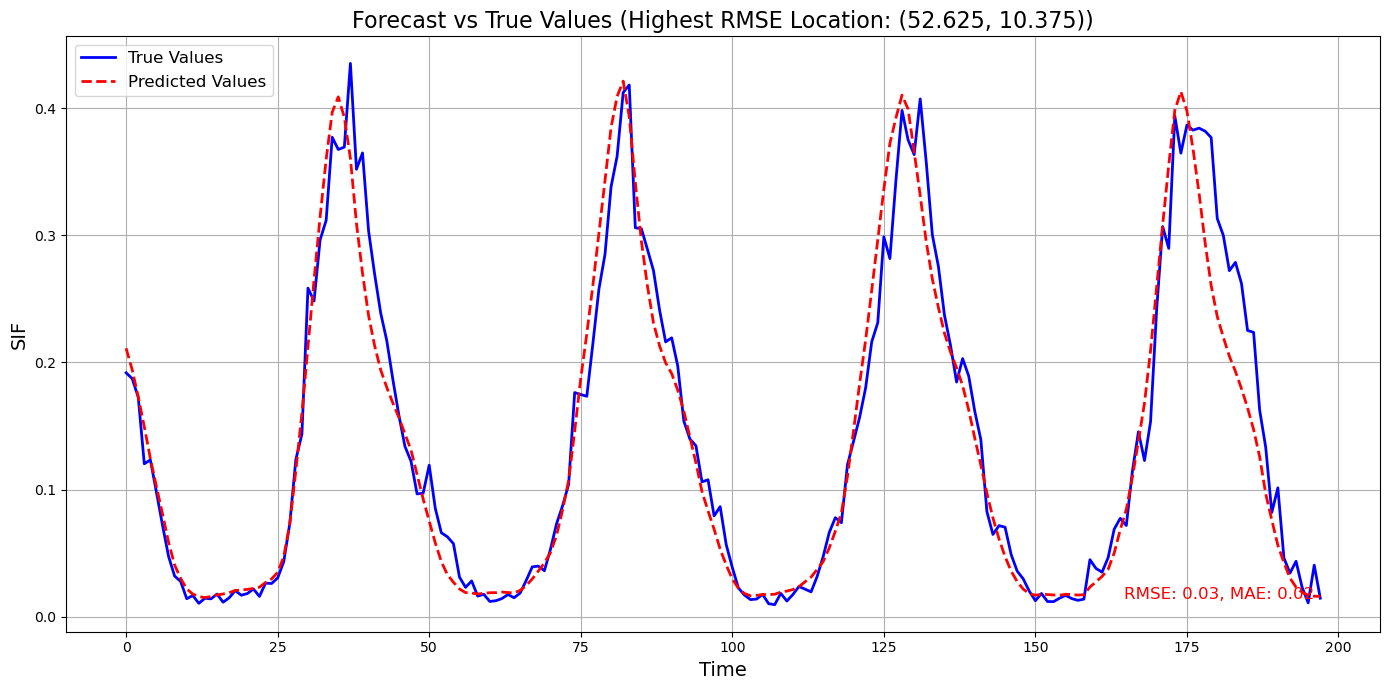

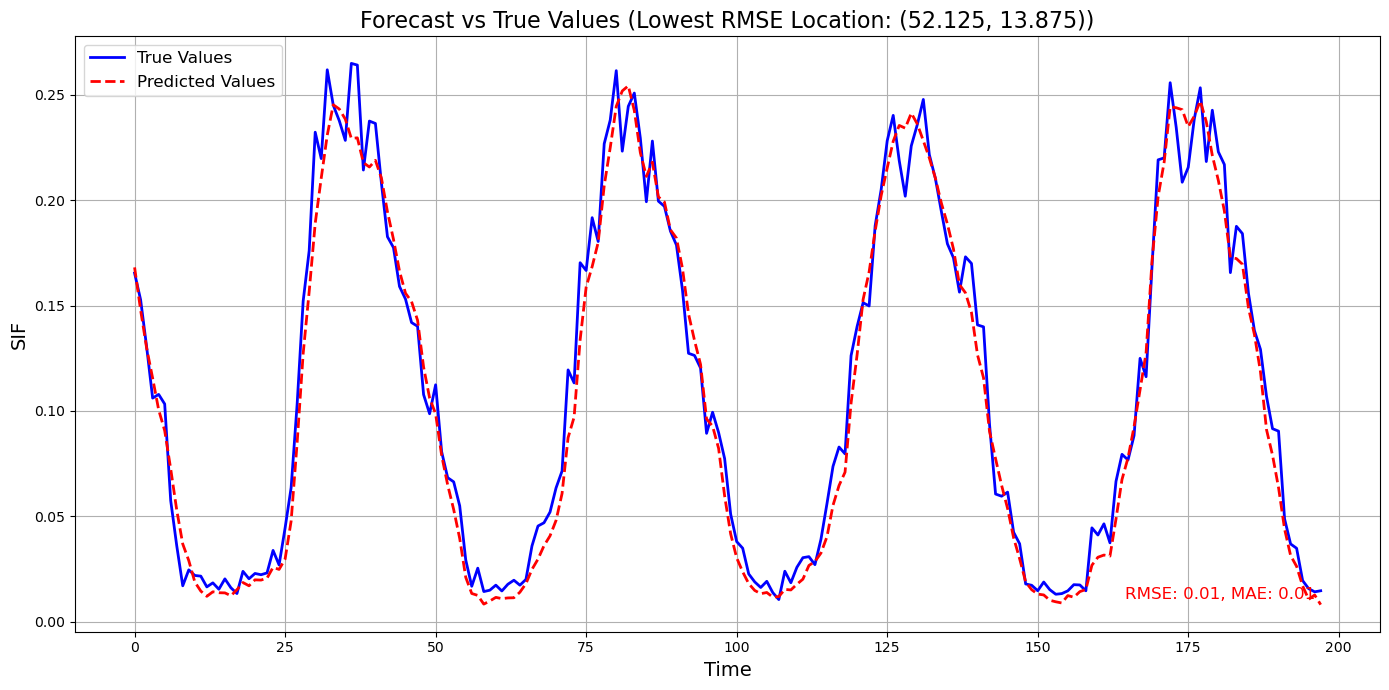

In [6]:
# unction to plot true vs predicted values
def plot_forecast(true_values, predicted_values, title, rmse, mae):
    plt.figure(figsize=(14, 7))
    plt.plot(true_values, label='True Values', color='blue', linewidth=2)
    plt.plot(predicted_values, label='Predicted Values', color='red', linestyle='--', linewidth=2)
    plt.title(title, fontsize=16)
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('SIF', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.tight_layout()

    # add scores to each plot
    plt.text(0.95, 0.05, f"RMSE: {rmse:.2f}, MAE: {mae:.2f}", 
                verticalalignment='bottom', horizontalalignment='right', 
                transform=plt.gca().transAxes, color='red', fontsize=12)
    plt.show()

# Plot for location with highest RMSE
plot_forecast(
    [val[0] for val in true_values_high_rmse],
    [val[0] for val in predicted_values_high_rmse],
    f'Forecast vs True Values (Highest RMSE Location: {highest_rmse_location})', rmse_high, mae_high
)

# Plot for location with lowest RMSE
plot_forecast(
    [val[0] for val in true_values_low_rmse],
    [val[0] for val in predicted_values_low_rmse],
    f'Forecast vs True Values (Lowest RMSE Location: {lowest_rmse_location})', rmse_low, mae_low
)

Locations with lowest RMSE: ['(52.125, 13.875)', '(49.375, 11.125)'], RMSEs: [0.012908714823424816, 0.013273913413286209]
Locations with highest RMSE: ['(50.625, 8.125)', '(52.625, 10.375)'], RMSEs: [0.029641209170222282, 0.030957287177443504]


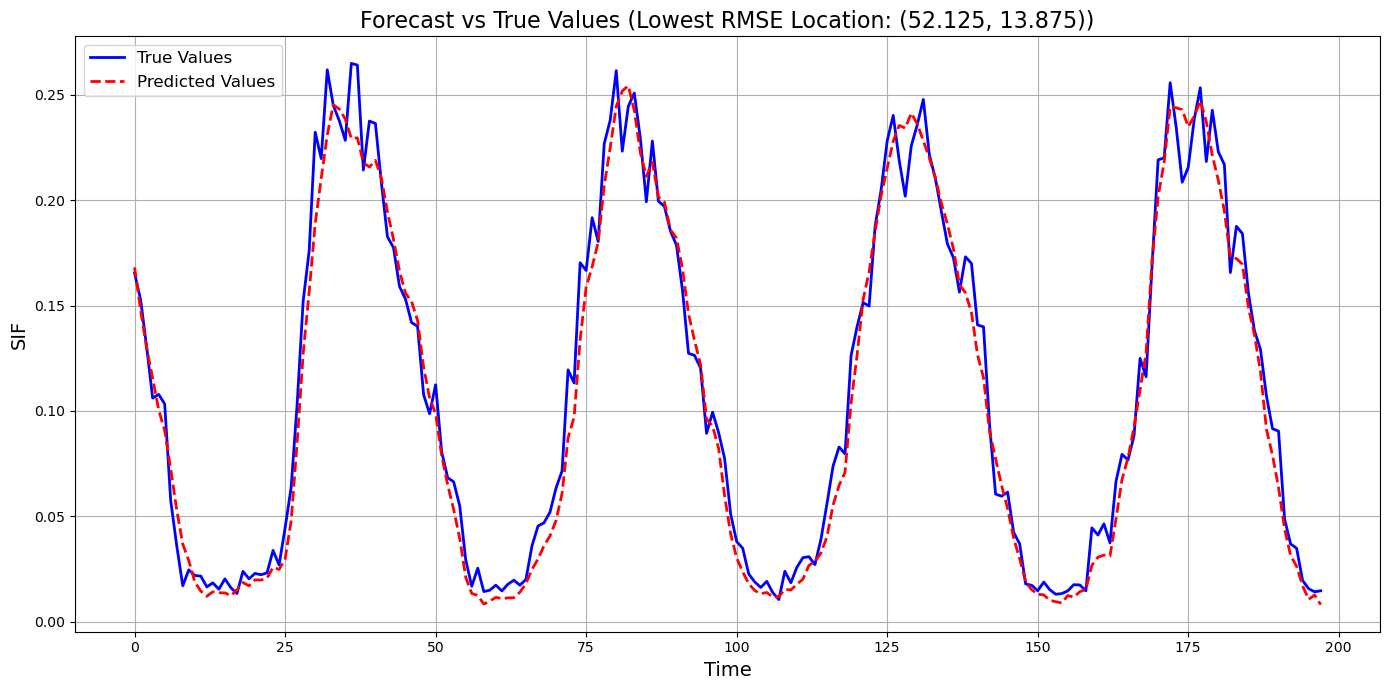

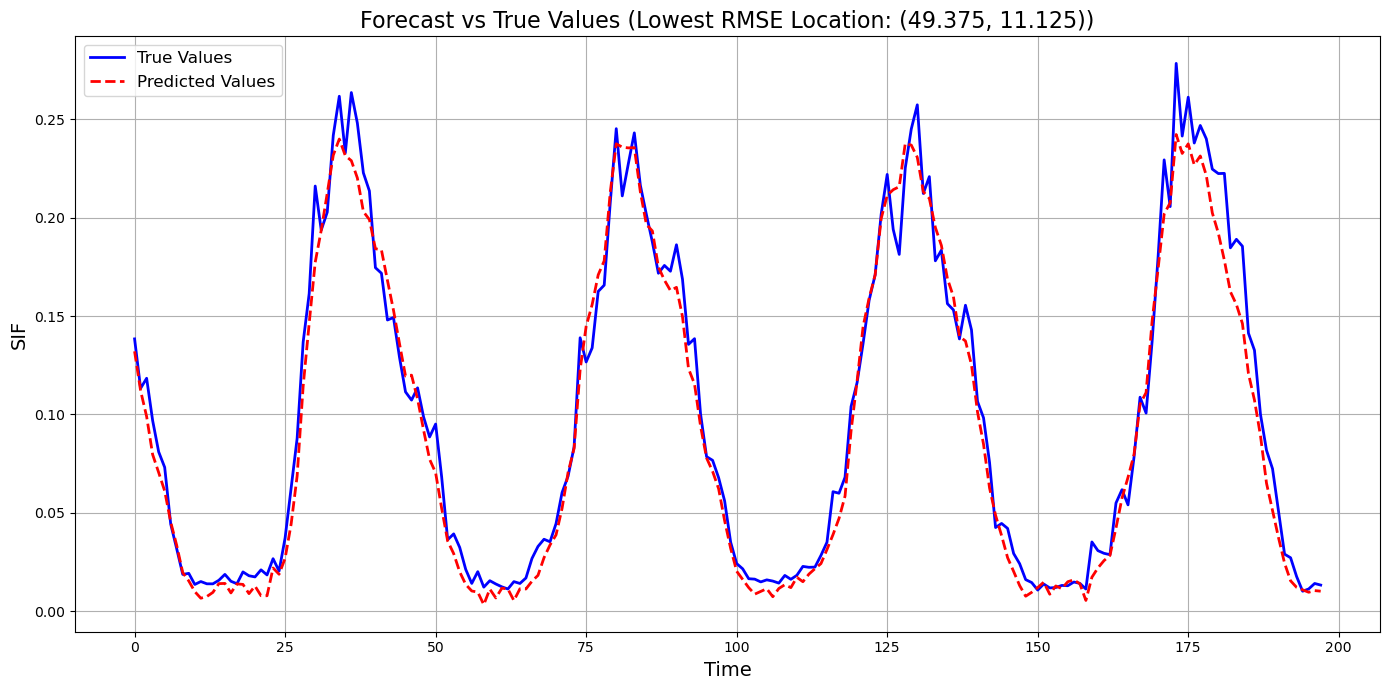

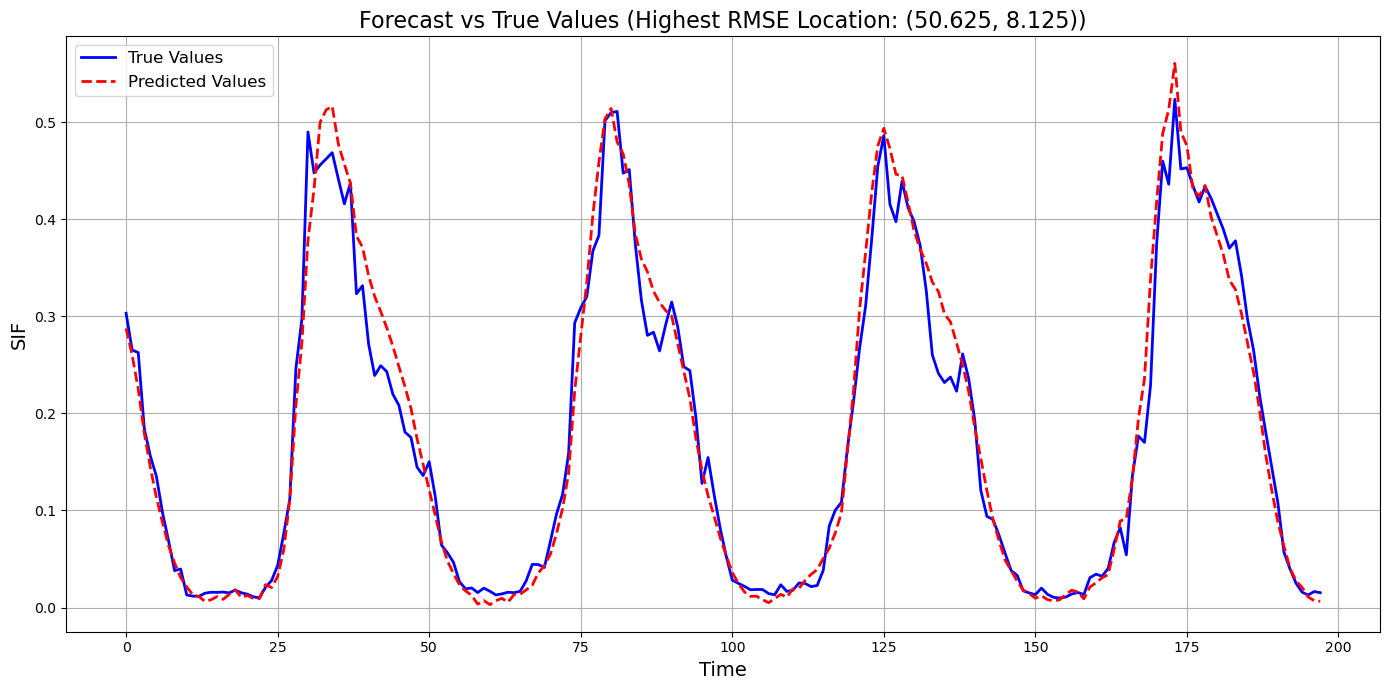

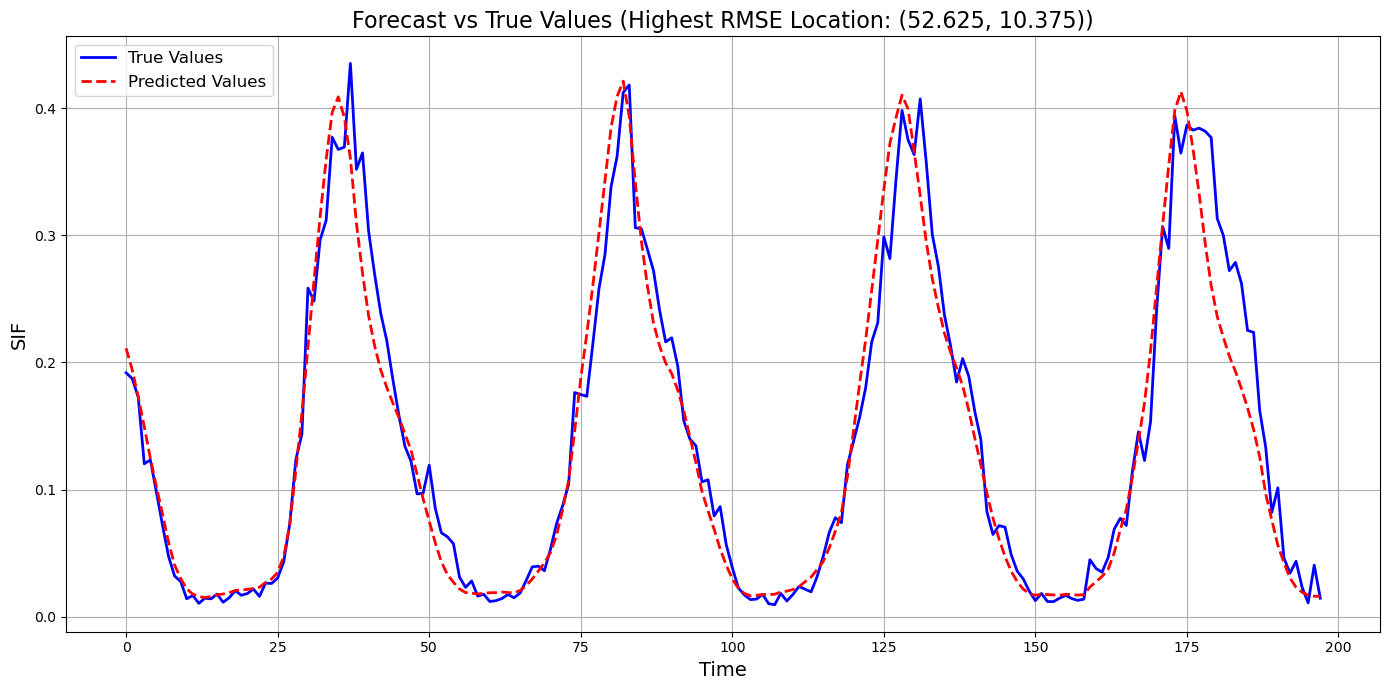

In [7]:



# Call the function with the example dictionary
plot_forecasts_from_dict(results_dict)


In [8]:
def subset_results_dict(results_dict):
    subset_dict = {}
    for key, value in results_dict.items():
        subset_dict[key] = {
            'best_params': value['best_params'],
            'evaluation': value['evaluation']
        }
    return subset_dict

res_sub = subset_results_dict(results_dict)

In [12]:
import json
import IPython.core.formatters

class JsonDumpTryingFormatter(
    IPython.core.formatters.PlainTextFormatter
):
    def __call__(self, obj):
        try:
            return json.dumps(obj, indent=2)
        except TypeError:
            return super().__call__(obj)

_ipy = IPython.get_ipython()
_formatters = _ipy.display_formatter.formatters
_formatters["text/plain"] = JsonDumpTryingFormatter()

res_sub[highest_rmse_location]

{
  "best_params": {
    "activation": "tanh",
    "batch_size": 25,
    "dropout_rate": 0.2,
    "epochs": 100,
    "learning_rate": 0.0001,
    "num_lstm_layers": 2,
    "units_lstm": 128
  },
  "evaluation": {
    "mae": 0.020632067695260048,
    "rmse": 0.030957287177443504
  }
}